In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    interaction = 0
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words) == 1:
            interaction = 0
            i_count = 0
        elif len(words)>1 and results_follow==1: # and words[0] not in omit_list
            if len(words)==2 and words[1]=="|":
                var_name = words[0]
                interaction = 1
                i_count = 0
            else:
                if interaction==0:
                    row_names.append(words[0])
                else:
                    row_names.append(var_name+"_"+words[0])                        
                
                if words[2]=='|':
                    t00= t0+1
                    t11 = t1+1
                else:
                    t00 = t0
                    t11 = t1

                buff_v = []
                for w in words[t00:t11]: 
                    w = w.replace(",","")
                    buff_v.append(w)
                table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def read_descriptive_stats(filename,keyword_data,keyword_col,ncols,rownames,start=2,debug=False):
    t0 = start
    t1 = ncols+start
    table_raw = np.empty(t1-t0)
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword_data:
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)))
        elif len(words)>1 and words[0] == keyword_col:
            colnames = words[t0:t1]

    return pd.DataFrame(table_raw[1:,:], columns=colnames, index=rownames)
 
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table 

In [3]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

time_periods_thin = []
for y in range(2006,2023):
    time_periods_thin.append(str(y))
    
time_periods = ["t08_11", "t11_14", "t14_17", "t17_20", "t20","t21","t22"]
period_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021'",'2022'"]
    
def rename_interaction(tab,int_subs):
    tab_chunk_1 = tab.iloc[0:7].copy()
    tab_chunk_2 = tab.iloc[7:].copy()
    tab_chunk_1.rename(index=int_subs,inplace=True)
    tab = pd.concat((tab_chunk_1,tab_chunk_2))
    return tab

# Parents Age 30-45

## Children Age <5 

In [4]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_age3045__5_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_age3045__5_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

In [5]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs[q][clab]['covid#sexo1_3']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1,coef_b2))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs_0k[q][clab]['covid#sexo1_3']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1,coef_b2))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'],all_tabs[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2'],all_tabs[q][lowerlab]['covid#sexo1_3']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_3'])

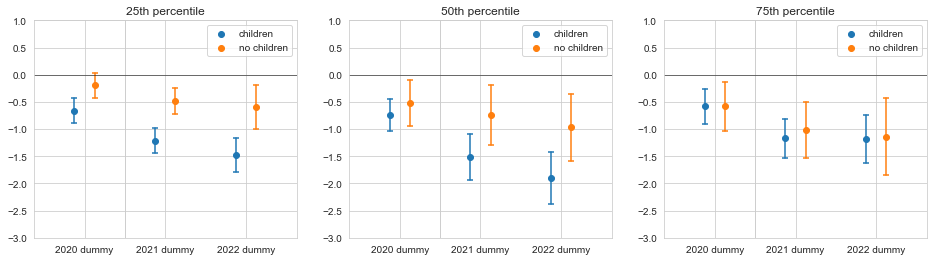

In [6]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,3),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,3.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3,1)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125,0.625,2.125],['2020 dummy','','2021 dummy','','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_simple_3045_5.pdf',format='pdf',bbox_inches='tight')
plt.show()

##  Children Age <10

In [7]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_age3045__10_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_age3045__10_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

In [8]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs[q][clab]['covid#sexo1_3']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1,coef_b2))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs_0k[q][clab]['covid#sexo1_3']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1,coef_b2))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'],all_tabs[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2'],all_tabs[q][lowerlab]['covid#sexo1_3']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_3'])

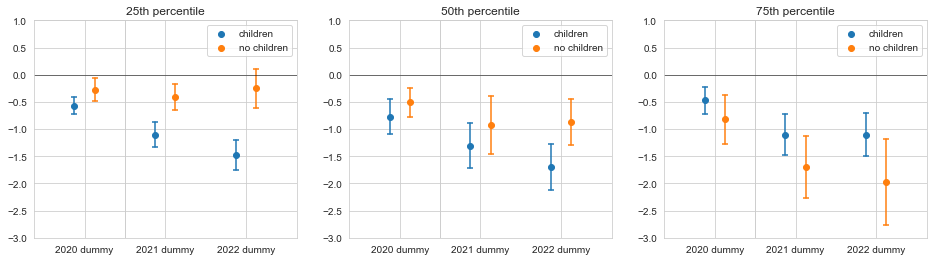

In [9]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,3),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,3.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3,1)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125,0.625,2.125],['2020 dummy','','2021 dummy','','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_simple_3045_10.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Children Age <15 

In [10]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_age3045__15_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_age3045__15_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

In [11]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs[q][clab]['covid#sexo1_3']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1,coef_b2))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs_0k[q][clab]['covid#sexo1_3']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1,coef_b2))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'],all_tabs[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2'],all_tabs[q][lowerlab]['covid#sexo1_3']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_3'])

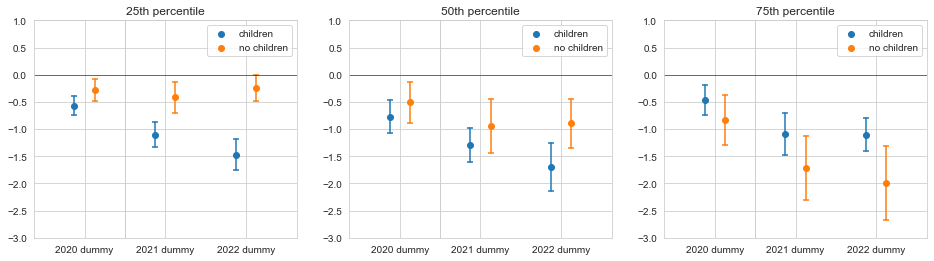

In [12]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,3),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,3.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3,1)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125,0.625,2.125],['2020 dummy','','2021 dummy','','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_simple_3045_15.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Children Age <18

In [13]:
path = './results/'
omits = ['sexo1#c.ttrend','sexo1#c.ttrend2',"covid#sexo1"]
# int_subs ={}
# for t in time_periods:
#     int_subs[t] = 'ten_'+t[1:]
name = "sqtreg_age3045__18_hemp_time_int_diff"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25 = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50 = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75 = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

name = "sqtreg_age3045__18_hemp_time_int_diff_0k"
file_split('{}.log'.format(name),path,startwords=['q25','q50','q75'],endword="_cons",
           header="ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_25_0k = read_table(path+'{}_1.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_50_0k = read_table(path+'{}_2.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)
tab_moms_75_0k = read_table(path+'{}_3.log'.format(name),
                         keyword='ten_y',rescale=1,ncols=6,start=2,omit_list=omits,index_to_int=False)

In [14]:
coeffs_period_children = {}
coeffs_period_nochildren = {}

upper_children,lower_children = {}, {}
upper_nochildren,lower_nochildren = {}, {}

clab = 'Coefficient'
lowerlab= "lower_95"
upperlab = "upper_95q"
all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

for q in [25,50,75]:
    coef_b0 = all_tabs[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs[q][clab]['covid#sexo1_3']
    coeffs_period_children[q] = np.hstack((coef_b0,coef_b1,coef_b2))
    
    coef_b0 = all_tabs_0k[q][clab]['covid#sexo1_1']
    coef_b1 = all_tabs_0k[q][clab]['covid#sexo1_2']
    coef_b2 = all_tabs_0k[q][clab]['covid#sexo1_3']
    coeffs_period_nochildren[q] = np.hstack((coef_b0,coef_b1,coef_b2))    
        
    upper_children[q] = (all_tabs[q][upperlab+str(q)]['covid#sexo1_1'],all_tabs[q][upperlab+str(q)]['covid#sexo1_2'],all_tabs[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_children[q] = (all_tabs[q][lowerlab]['covid#sexo1_1'],all_tabs[q][lowerlab]['covid#sexo1_2'],all_tabs[q][lowerlab]['covid#sexo1_3']) 
    
    upper_nochildren[q] = (all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_1'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_2'],
                           all_tabs_0k[q][upperlab+str(q)]['covid#sexo1_3'])
    lower_nochildren[q] = (all_tabs_0k[q][lowerlab]['covid#sexo1_1'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_2'],
                           all_tabs_0k[q][lowerlab]['covid#sexo1_3'])

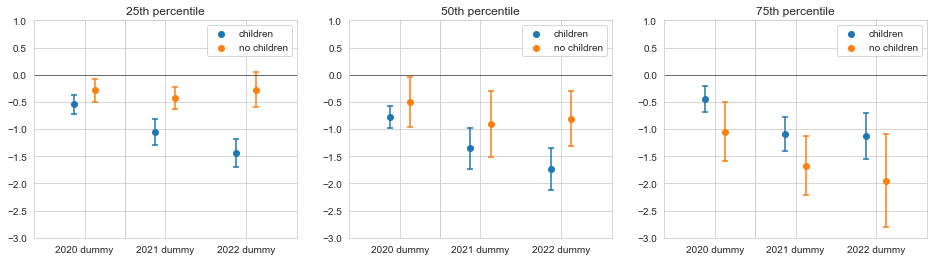

In [15]:
coeff_range = np.arange(len(coeffs_period_children.values()))
N = coeff_range.size
colors = sn.color_palette()
ylims = ((0,4),(3,7),(8,12))

date_range = np.arange(2005,2022)

all_tabs = dict(zip([25,50,75],[tab_moms_25,tab_moms_50,tab_moms_75]))
all_tabs_0k = dict(zip([25,50,75],[tab_moms_25_0k,tab_moms_50_0k,tab_moms_75_0k]))

sn.set_style('whitegrid')
plt.figure(figsize=(16,4))
for iq,q in enumerate(all_tabs.keys()):   
    
    plt.subplot(131+iq)
    plt.title('{}th percentile'.format(q))
    plt.scatter(np.arange(0,3),coeffs_period_children[q],marker='o',color=colors[0],label='children')
    plt.scatter(np.arange(0,3),upper_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0,3),lower_children[q],marker='_',color=colors[0])
    plt.scatter(np.arange(0.25,3.25,1),coeffs_period_nochildren[q],marker='o',color=colors[1],label='no children')
    plt.scatter(np.arange(0.25,3.25,1),upper_nochildren[q],marker='_',color=colors[1])
    plt.scatter(np.arange(0.25,3.25,1),lower_nochildren[q],marker='_',color=colors[1])
    for i in range(3):
        plt.plot((i,i),(lower_children[q][i],upper_children[q][i]),c=colors[0])
        plt.plot(((0.25+i),(0.25+i)),(lower_nochildren[q][i],upper_nochildren[q][i]),c=colors[1])
    plt.axhline(c='k',lw=0.5)
    plt.ylim(-3,1)
    plt.xlim(-0.5,2.75)
    plt.legend()
    plt.xticks([0.125,0.625,1.125,0.625,2.125],['2020 dummy','','2021 dummy','','2022 dummy'])
#     plt.xlabel('2020 dummy                                    2021 dummy')
plt.savefig('./plots_tenure/coeffs_compare_simple_3045_18.pdf',format='pdf',bbox_inches='tight')
plt.show()